# Nonlinearities

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

from tqdm import tqdm
from tensorflow.keras.utils import to_categorical

import torch
from torch import nn
from torchsummary import summary

(800, 2) (200, 2) (800,) (200,)


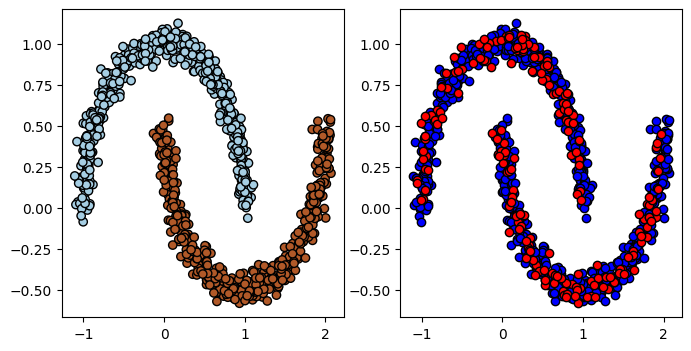

In [2]:
# Configuration options
num_classes = 2
X, y = make_moons(n_samples= 1000 , noise=0.05)

X_train, X_test, y_train, y_test = train_test_split( X , y , test_size = 0.20, random_state = 1)
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

_, axes = plt.subplots (1,2, figsize=(8,4))

axes[0].scatter(X[:,0], X[:,1], c=y, edgecolors='k' ,cmap='Paired')
axes[1].scatter(X_train[:,0], X_train[:,1], c='b', edgecolors='k')
axes[1].scatter(X_test[:,0], X_test[:,1], c='r', edgecolors='k');

In [ ]:
# # Convert into greyscale
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')

In [3]:
# Convert target classes to categorical ones
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Set the input shape
input_shape = (X_train.shape)
print(f'Feature shape: {input_shape}')

Feature shape: (800, 2)


In [4]:
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(800, 2) (200, 2) (800, 2) (200, 2)


## Create a graph model

In [5]:
model = nn.Sequential(
    #pide el numero de entradas(2)o caracteristicas
    #cuantos perceptrones va utilizar(2)
    nn.Linear(2, 5000), nn.ReLU(), # la segunda Funcion nolineal
    nn.Linear(5000,2), nn.Sigmoid(), #(entradas = salidas de arriba, salidasPerceptrones )
   #ReLU es una funcion no lineal a diferencia del kernel no necesita parametros

)

model.cuda() #Traduce el modelo a Cuda para que se vaya a la cpu/gpu
#sumary hace el resumen del modelo
summary(model, input_size=(2,), device='cuda') #device: cuda o cpu
#por defecto torch manda el modelo a cpu, device='cpu'
# print (model)

#este imprime x0[m00],x1[m01],b[0], [m10],[m11],b[2] = parametros

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 5000]          15,000
              ReLU-2                 [-1, 5000]               0
            Linear-3                    [-1, 2]          10,002
           Sigmoid-4                    [-1, 2]               0
Total params: 25,002
Trainable params: 25,002
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.10
Estimated Total Size (MB): 0.17
----------------------------------------------------------------


## Define loss function and optimizer

In [6]:
# loss = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-2)

# model.cuda()
loss.cuda()

MSELoss()

## Train model

In [7]:
epochs = 800
batch_size = 200
losses = []

# start_time = time.time()
progress = tqdm(range( epochs ), ncols=110) #ncols Long de la barra de progreso

for epoch in progress :
  #
  batch_losses = 0

#es un for para convertir los array a tensor para poderlos mandar a cuda
  for batch_i in range(0, len(X_train), batch_size):
    #
    batch_X = X_train[ batch_i : batch_i + batch_size ]
    batch_y = y_train[ batch_i : batch_i + batch_size ]
    batch_X = torch.from_numpy(batch_X).to(torch.float32).cuda()
    batch_y = torch.from_numpy(batch_y).to(torch.float32).cuda()

    # 1. Zero the gradients
    optimizer.zero_grad() #Reinicializar los gradientes

    # 2. Perform forward pass
    predictions = model( batch_X ) #Hacer las predicciones es hacer un forward

    # 3. Compute loss
    batch_loss = loss( batch_y , predictions ) #devuelve un tensor "especial"

    # 4. Perform backward pass
    batch_loss.backward() # calcular el gradiente es hacer un backwar

    # 5. Optimize parameters
    optimizer.step()

    ## Save stats
    batch_losses += batch_loss.item() #es necesario .item para obtener el valor numerico

    # elapsed_time = time.time() - start_time #lo quitamos porque la barra lo hace automaticamente

  progress.set_description("Epoch [%d/%d] [Loss: %f]" % (epoch, epochs,
                                                                   batch_losses/(len(X_train)/batch_size)))


  # progress.set_description(f"Epoch [%d/%d] [Loss: %f] time: %3f" % (epoch, epochs,
  #                                                                  batch_loss.item(),
  #                                                                  elapsed_time))

  losses.append(batch_losses/(len(X_train)/batch_size))


Epoch [799/800] [Loss: 0.014169]: 100%|████████████████████████████████████| 800/800 [00:07<00:00, 113.87it/s]


## Plot results

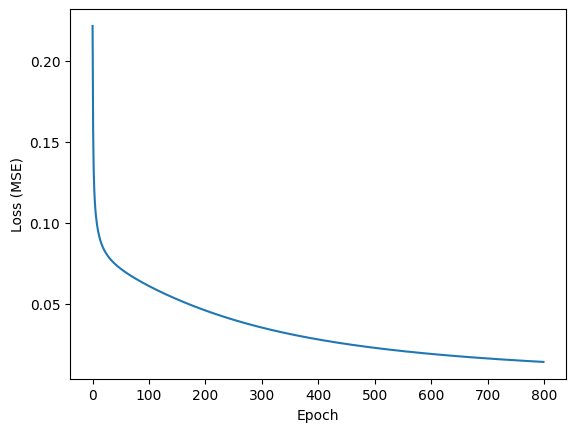

In [8]:
plt.plot(np.array(losses))
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)");

In [9]:
h_min, h_max = X_test[:,0].min()-0.2, X_test[:,0].max()+0.2
v_min, v_max = X_test[:,1].min()-0.1, X_test[:,1].max()+0.1

# Crear el grid de las fronteras de decision
h_grid, v_grid = np.meshgrid(np.linspace( h_min , h_max , 200), np.linspace( v_min , v_max , 200))

# Predecir los valores del grid
grid_ = torch.from_numpy( np.c_[h_grid.ravel(), v_grid.ravel()] ).to(torch.float32).cuda()
predictions = model( grid_ )
predictions = np.argmax( predictions.detach().cpu().numpy() , axis=1) #para convertir en numpy
print (predictions.shape)

# Encajar las predicciones al tamaño del grid
predictions = predictions.reshape(h_grid.shape)
print (h_grid.shape, v_grid.shape, predictions.shape)

(40000,)
(200, 200) (200, 200) (200, 200)


[]

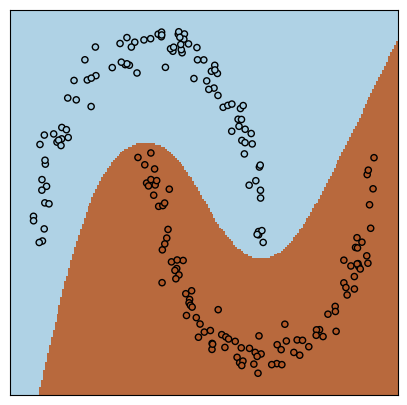

In [10]:
_, ax = plt.subplots (figsize=(5,5))

# Put the result into a color plot
plt.pcolormesh( h_grid , v_grid , predictions, cmap='Paired', alpha=0.9)

ax.scatter( X_test[:,0] , X_test[:,1] , c = np.argmax(y_test, axis=1) , edgecolors='k', s=20, cmap='Paired')

# ax.set_xlim(h_grid.min()-.1, h_grid.max()+.1)
# ax.set_ylim(v_grid.min()-.1, v_grid.max()+.1)

ax.set_xticks(())
ax.set_yticks(())